In [117]:
import os
os.chdir("..")
from typing import Mapping,Iterable, Iterator, Tuple, TypeVar,Optional,Callable,Dict
from itertools import islice
from rl.distribution import Choose
from rl.distribution import Categorical
from rl.prediction_utils import fmrp_episodes_stream
from rl.markov_process import (MarkovRewardProcess,
                               FiniteMarkovRewardProcess, TransitionStep)
from rl.function_approx import learning_rate_schedule
from rl.returns import returns


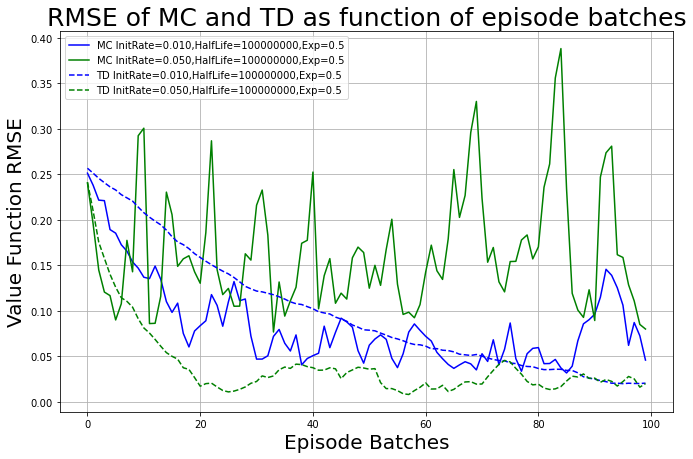

In [118]:
class RandomWalkMRP(FiniteMarkovRewardProcess[int]):
    '''
    This MRP's states are {0, 1, 2,...,self.barrier}
    with 0 and self.barrier as the terminal states.
    At each time step, we go from state i to state
    i+1 with probability self.p or to state i-1 with
    probability 1-self.p, for all 0 < i < self.barrier.
    The reward is 0 if we transition to a non-terminal
    state or to terminal state 0, and the reward is 1
    if we transition to terminal state self.barrier
    '''
    barrier: int
    p: float

    def __init__(
        self,
        barrier: int,
        p: float
    ):
        self.barrier = barrier
        self.p = p
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[int, Optional[Categorical[Tuple[int, float]]]]:
        d: Dict[int, Optional[Categorical[Tuple[int, float]]]] = {
            i: Categorical({
                (i + 1, 0. if i < self.barrier - 1 else 1.): self.p,
                (i - 1, 0.): 1 - self.p
            }) for i in range(1, self.barrier)
        }
        d[0] = None
        d[self.barrier] = None
        return d


if __name__ == '__main__':
    from rl.chapter10.prediction_utils import compare_td_and_mc

    this_barrier: int = 10
    this_p: float = 0.5
    random_walk: RandomWalkMRP = RandomWalkMRP(
        barrier=this_barrier,
        p=this_p
    )
    compare_td_and_mc(
        fmrp=random_walk,
        gamma=1.0,
        mc_episode_length_tol=1e-6,
        num_episodes=700,
        learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
        initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
        plot_batch=7,
        plot_start=0
    )

# P3
$V(S_t)=\gamma *V(S_{t-1})+R_{t}=\gamma ^2*V(S_{t-2})+\gamma*R_{t-1}+R_{t}.....$
<br> Plug this into $G_T-V(S_t)$
<br> We will get the expected result

# p1 p2 p4

In [108]:
# n-bootstrap for prediction
S = TypeVar('S')
A = TypeVar('A')

def n_bootstrap_tabular(
    n: int,
    alpha: float,
    fmrp: FiniteMarkovRewardProcess[S],
    gamma: float,
    num_iter: int
)-> Dict[S,float]:
    
    value_function: Optional[Tuple[S,float]]={}
    traces=fmrp_episodes_stream(fmrp)
    for _ in range(num_iter):
        trace=next(traces)
        effect_n: int=0
        effect_trace: Tuple[float,float,float]=[]
        # store the actual length and trace
        while True:
            try:
                sample=next(trace)
                state, nxt_state, reward=sample.state,sample.next_state,sample.reward
                effect_n=effect_n+1
                effect_trace.append((state, nxt_state, reward))
            except StopIteration:
                break
        # Actual algorithm iterations
        for step in range(effect_n):
                            
            # Terminate this trace if n-step s not available
            if step+n>effect_n:
                break
            experience_4_step=effect_trace[step:step+n]
            state, _ , reward=effect_trace[step]
            if state not in value_function:
                value_function[state]=0
            if effect_trace[step+n-1][1] not in value_function:
                value_function[effect_trace[step+n-1][1]]=0
            # else Calculate G_t
            G=0
            cum_gamma=1
            for boot in experience_4_step[:-1]:
                nxt_reward=boot[2]
                G=G+cum_gamma*nxt_reward
                cum_gamma=cum_gamma*gamma
            G=G+cum_gamma*effect_trace[step+n-1][2]
            # Last step of update
            value_function[state]=value_function[state]+alpha*(G+value_function[effect_trace[step+n-1][1]]\
                                                               -value_function[state])
    return value_function

## value_function after 100000 time steps in Bootstrap(n)

In [105]:
n_bootstrap_tabular(
    n=3,
    alpha=0.1,
    fmrp=random_walk,
    gamma=1,
    num_iter=100000)

{6: 0.5647424003401343,
 5: 0.4950023499494127,
 7: 0.6440282559004166,
 4: 0.3883375832321269,
 8: 0.6385763980475683,
 9: 0.703973132004283,
 10: 0,
 2: 0.30685668176739644,
 3: 0.24434590446180354,
 1: 0.2896952610253851,
 0: 0}

## output is correct

In [125]:
# TD(lambda)
S = TypeVar('S')
A = TypeVar('A')

def TD_lambda(
    alpha: float,
    lamda: float,
    fmrp: FiniteMarkovRewardProcess[S],
    gamma: float,
    num_iter: int
)-> Dict[S,float]:
    
    value_function: Optional[Tuple[S,float]]={}
    traces=fmrp_episodes_stream(fmrp)
    for _ in range(num_iter):
        trace=next(traces)
        eligib: Optional[Tuple[S,float]]={}
        while True:
            try:
                sample=next(trace)
                state, nxt_state, reward=sample.state,sample.next_state,sample.reward
                if state not in value_function:
                    value_function[state]=0
                if nxt_state not in value_function:
                    value_function[nxt_state]=0
                if state not in eligib:
                    eligib[state]=0
                 # update eligib trace   
                for i in eligib:
                    eligib[i]=eligib[i]*gamma*lamda
                    
                eligib[state]=eligib[state]+1
                # update all states
                for s in value_function:
                    if s not in eligib:
                        eligib[s]=0
                    value_function[s]=value_function[s]+alpha*\
                                    (reward+gamma*value_function[nxt_state]-value_function[s])*eligib[s]
                                    
            except StopIteration:
                break
                
                
    return value_function

In [ ]:
TD_lambda(
    lamda=0.97,
    alpha=0.01,
    fmrp=random_walk,
    gamma=1,
    num_iter=1000000)

## TD(lamba) output is correct